## Imports

In [ ]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
import photontorch as pt
plt.rcParams['figure.figsize'] = (1,4)

## Networks and Circuits

Networks are the core of Photontorch. Custom networks can easily be created by subclassing `pt.Network`. First, all network subcomponents are defined as attributes of the network, after which the ports of the subcomponents can be linked together with the `link` method of `pt.Network`.

The `link` method takes an arbitrary number of string arguments. Each argument contains the component name together with a port number in front of and a port number behind the name (e.g. `"0:wg:1"`). The port number behind the name will connect to the port number in front of the next name. The first component does not need a port number in front of it, while the last component does not need a port number behind.

Let's start by creating an all-pass filter.

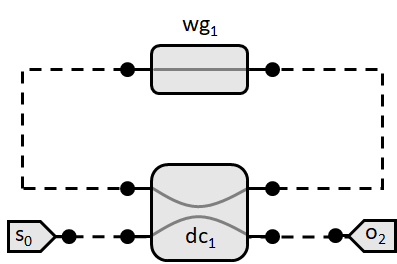

In [ ]:
class AllPass(pt.Network):
    def __init__(self, length=1e-5, neff=2.34, ng=3.4, loss=1000):
        super(AllPass, self).__init__() # always initialize first
        self.wg1 = pt.Waveguide(length=length, neff=neff, ng=ng, loss=loss, trainable=True)
        self.dc1 = pt.DirectionalCoupler(coupling=0.3, trainable=True)
        self.link("dc1:2", "0:wg1:1", "3:dc1")
        
# see if the network is terminated
print(list(AllPass().free_idxs))

Here a link was created where port 2 of the directional coupler was connected with port 0 of the waveguide and port 1 of the waveguide was connected with port 3 of the directional coupler. The port order of each component can be found in its docstring.

During the definition of the subcomponents, the `trainable` flag was set to `True` for the directional coupler and the waveguide. This is a flag that makes the parameters of the waveguide and the directional coupler optimizable with gradient descent and has no effect on the simulation itself.

A network is called *terminated* if no open ports are left. The network defined above is not terminated as it has two free indices left: `0` and `1`, which are respectively port 0 and port 1 of the directional coupler. A source and a detector (each components with a single port) can for example be added to terminate the network and form a closed circuit:

In [ ]:
class Circuit(pt.Network):
    def __init__(self, length=1e-5, neff=2.34, ng=3.4, loss=1000):
        super(Circuit, self).__init__()
        self.allpass = AllPass(length, neff, ng, loss)
        self.source = pt.Source()
        self.detector = pt.Detector()
        
        # note that you link with the allpass circuit as if it was
        # a single component. You do not link with the subcomponents
        # of the allpass component!
        self.link("source:0", "0:allpass:1", "0:detector")

# see if the network is terminated
print(list(Circuit().free_idxs))

## Simulations

To start doing simulations, one first has to create an instance of the ciruit to simulate:

In [ ]:
circuit = Circuit(length=1.2e-5, neff=2.84, ng=3.2, loss=3e4)

Photontorch supports time and frequency domain simulations. All the simulation parameters, i.e. the simulation environment, are set with a context-manager (`with`-block). Below an example on how to do a frequency-domain simulation on the Allpass filter defined above:

In [ ]:
# create simulation environment
freq_env = pt.Environment(
    wavelength=1e-6*np.linspace(1.45, 1.65, 1000),
    frequency_domain=True
)

with freq_env:
    # perform simulation
    detected = circuit(source=1) # constant source with amplitude 1
    
    # plot detected power
    circuit.plot(detected);
    plt.savefig('images/outputs/00_1.png')
    plt.show()

Time domain simulations are just as easily done:

In [ ]:
# create simulation environment
env = pt.Environment(dt=1e-15, t_end=2.5e-12, wavelength=1.55e-6)

# create time-dependent source
single_source = np.sin(env.time*5e13)

with env:
    # perform simulation
    detected = circuit(source=single_source)

    # plot detected power
    circuit.plot(detected);
    plt.savefig('images/outputs/00_2.png')
    plt.show()

Two independent simulations can also be batched together. Each different source function which will then propagate through the circuit in parallel (but independant of each other). This is a very efficient way of doing multiple simulations at once. It can also be used in the optimization phase for more stable training.

In [ ]:
# create time-dependent source
double_source = np.stack([
    np.cos(env.time*2.5e13),
    np.sin(env.time*5e13),
], -1)

with env:
    detected = circuit(source=double_source)
    circuit.plot(detected);
    plt.savefig('images/outputs/00_3.png')
    plt.show()

One can also simulate multiple wavelengths at the same time, just by changing the simulation environment a little bit.

In [ ]:
with env.copy(wavelength=[1.545e-6, 1.55e-6, 1.56e-6]):
    detected = circuit(source=1) # constant source with amplitude 1
    circuit.plot(detected);
    plt.savefig('images/outputs/00_4.png')
    plt.show()

## Optimization and Training

The optimizable parameters of a network can be printed out (just like in PyTorch):

In [ ]:
for p in circuit.parameters():
    print(p)

In this case, the circuit has two parameters corresponding to an additional phase factor in the ring and the coupling coefficient of the directional coupler respectively. These two parameters can be optimized to make the network approximate a particular target. For this, native [PyTorch optimizers](https://pytorch.org/docs/stable/optim.html) can be used. 

Let's try to shift the resonance in the ring from 1550nm to 1525 nm while simulataneously making the transmission as low as possible by just optimizing these two parameters:

In [ ]:
# define simualation environment
train_env = pt.Environment(
    wavelength=1525e-9, # we want minimal transmission at this wavelength
    frequency_domain=True, # we will do frequency domain simulations
    enable_grad=True, # gradient need to be tracked in order to use gradient descent.
)

# define target for the simulation, lets take 0 (ideally no transmission at resonance)
target = 0

# let's define an optimizer.
# The Adam optimizer is generally considered to be the best
# gradient descent optimizer out there:
optimizer = torch.optim.Adam(circuit.parameters(), lr=0.1)

# do the training
with train_env:
    for epoch in range(100):
        optimizer.zero_grad() # reset the optimizer and gradients
        detected = circuit(source=1) # simulate
        loss = ((detected-target)**2).mean() # calculate mse loss
        loss.backward() # calculate the gradients on the parameters
        optimizer.step() # update the parameters according to the gradients
        
# view result
with freq_env:
    detected = circuit(source=1) # constant source with amplitude 1
    circuit.plot(detected);
    plt.savefig('images/outputs/00_5.png')
    plt.show()

# print parameters
for p in circuit.parameters():
    print(p)

A shift in resonance can be seen while the transmission at resonance is also clearly lower (approaching zero) than before.

## Defining custom components

Components are the building blocks of Photontorch. Photontorch has a growing number of default components available, it is however reasonably easy to define your own components.

Below an example on how one can define a directional coupler. A component with 4 ports and two parameters: $\tau$ the transmission and $\kappa$ the coupling between the arms.

In [ ]:
from torch.nn import Parameter
from photontorch import Component

class DirectionalCoupler(Component):
    num_ports = 4 # this class variable always needs to be defined
    def __init__(self, tau=np.sqrt(0.5), kappa=np.sqrt(0.5)):
        super(DirectionalCoupler, self).__init__()
        self.tau = Parameter(torch.tensor(tau))
        self.kappa = Parameter(torch.tensor(kappa))

This was reasonably easy. However, the S-matrix still has to be defined. A directional coupler with the following port order
```
3    2
 \__/
 /‾‾\
0    1
```
has an [S-matrix]( https://en.wikipedia.org/wiki/Power_dividers_and_directional_couplers#S-parameters) that looks as follows:
\begin{align*}
S &= \begin{pmatrix}
0 & \tau & i\kappa & 0 \\
\tau & 0 & 0 & i\kappa \\
i\kappa & 0 & 0 & \tau \\
0 & i\kappa & \tau & 0
\end{pmatrix}.
\end{align*}

This S-matrix thus essentially links ports (0,1) and ports (2,3) with a transmission $\tau$, while the links (0,2) and (1,3) are characterized with a coupling $\kappa$.

The S-matrix can be defined by defining the method `set_S` of the `DirectionalCoupler` component. This method takes one argument: the empty (all-zero) S-matrix `S` which needs to be filled with elements by that method. The method itself does not return anything.

However, there is a catch. One cannot just put these S-matrix elements into the `S`-tensor. First of all, the S-matrix needs to be defined for all wavelengths of the simulation. Therefore, the S-matrix has an extra dimension  to fill different `S`-elements for different wavelengths. The wavelength information can be obtained for the simulation environment, which is saved in the component as `self.env`. 
Secondly, PyTorch does not support complex tensors, therefore the `S` tensor to fill with elements is split into a real and imaginary part, such that the total shape of `S` is:
```
    (2, # wavelengths, # ports, # ports)
```
the `set_S` method can thus be written as follows:

In [ ]:
class DirectionalCoupler(Component):
    # ... [initialization]
    def set_S(self, S):
        # this won't be used here, but this is how to get the
        # wavelengths (and if necessary other information)
        # from the simulation environment to be able to calculate
        # the appropriate S-matrix elements.
        wls = self.env.wavelength
        
        # real part scattering matrix (transmission):
        # (same transmission for all wavelengths)
        S[0, :, 0, 1] = S[0, :, 1, 0] = self.tau
        S[0, :, 2, 3] = S[0, :, 3, 2] = self.tau

        # imag part scattering matrix (coupling):
        # (same transmission for all wavelengths)
        S[1, :, 0, 2] = S[1, :, 2, 0] = self.kappa
        S[1, :, 1, 3] = S[1, :, 3, 1] = self.kappa
        